In [1]:
import numpy as np
import pandas as pd

BTC = pd.read_csv("BTC-USD.csv",parse_dates=True,index_col='Date')
BTC.dropna(inplace=True) 
BTC.drop(columns=['Open','High','Low','Close','Volume'],inplace=True)
BTC['Adj Close_BTC'] = BTC['Adj Close']
BTC['LogPrice_BTC']= np.log(BTC['Adj Close_BTC'])
BTC.drop(columns=['Adj Close'],inplace=True)
BTC.head()

,Adj Close_BTC,LogPrice_BTC
Date,,
2019-11-03,9235.354492,9.130794
2019-11-04,9412.612305,9.149806
2019-11-05,9342.527344,9.142332
2019-11-06,9360.879883,9.144295
2019-11-07,9267.561523,9.134276


In [2]:
ETH = pd.read_csv("ETH-USD.csv",parse_dates=True,index_col='Date')
ETH.dropna(inplace=True)
ETH.drop(columns=['Open','High','Low','Close','Volume'],inplace=True)
ETH['Adj Close_ETH'] = ETH['Adj Close']
ETH['LogPrice_ETH']= np.log(ETH['Adj Close_ETH'])
ETH.drop(columns=['Adj Close'],inplace=True)
ETH.head()

,Adj Close_ETH,LogPrice_ETH
Date,,
2019-11-03,182.425018,5.206339
2019-11-04,186.355194,5.227654
2019-11-05,189.304169,5.243355
2019-11-06,191.593842,5.255378
2019-11-07,187.976547,5.236317


In [3]:
correl = np.corrcoef(BTC['Adj Close_BTC'],ETH['Adj Close_ETH'])
correl

array([[1.        , 0.91810068],
       [0.91810068, 1.        ]])

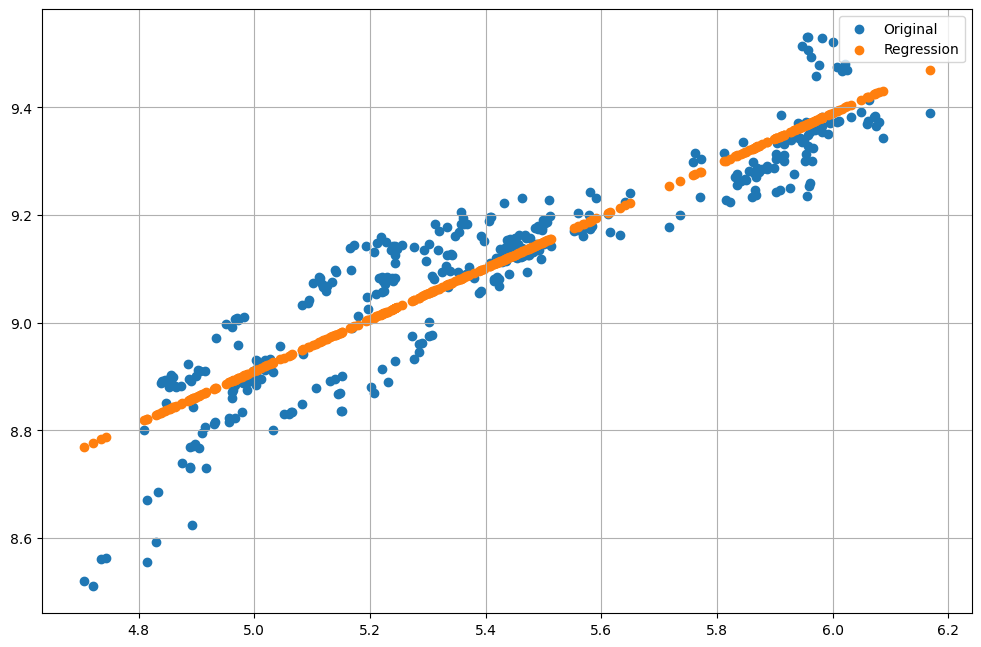

R2: 0.8515374239583957
n value:  0.47933537785038144


In [4]:

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


x = ETH['LogPrice_ETH'].values.reshape(-1,1)
y = BTC['LogPrice_BTC'].values.reshape(-1,1)


model = LinearRegression()
model.fit(x,y)
r_sq = model.score(x,y)

n = float(model.coef_[0])
intercept = float(model.intercept_)

regression_price = intercept + n * x

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.scatter(x,y, label='Original')
plt.scatter(x,regression_price,label='Regression')
plt.grid()
plt.legend()
plt.show()

print('R2:', r_sq)
print('n value: ', n)

In [5]:
from statsmodels.tsa.stattools import adfuller
spread = BTC['LogPrice_BTC'].values - n * ETH['LogPrice_ETH'].values - intercept

result = adfuller(spread)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.390766
p-value: 0.144359
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


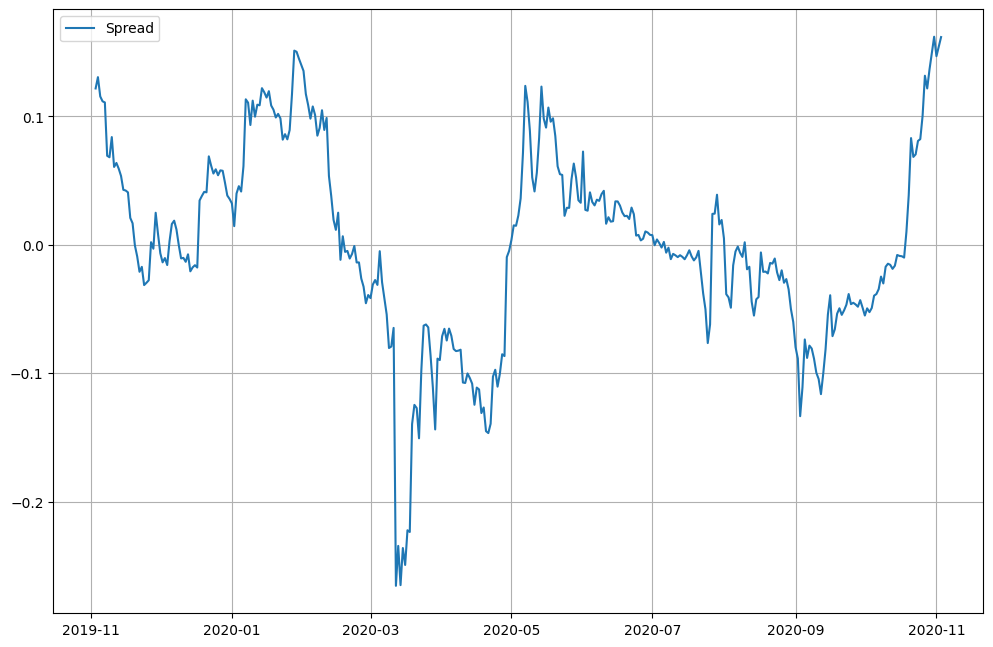

In [6]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(BTC.index.values,spread,label='Spread')
plt.grid()
plt.legend()
plt.show()

In [7]:

d = {'Date': BTC.index.values,
          'Spread': spread}

Spread = pd.DataFrame(data=d)
Spread.set_index('Date',inplace=True)

Spread['MA'] = Spread['Spread'].rolling(10).mean()
Spread['MSTD'] = Spread['Spread'].rolling(10).std()
Spread.dropna(inplace=True)
Spread['Z'] = (Spread['Spread'] - Spread['MA'])/Spread['MSTD']
Spread.head()

,Spread,MA,MSTD,Z
Date,,,,
2019-11-12,0.063690,0.093555,0.027013,-1.105592
2019-11-13,0.059233,0.087311,0.027008,-1.039630
2019-11-14,0.053582,0.079623,0.024150,-1.078260
2019-11-15,0.042783,0.072355,0.023078,-1.281350
2019-11-16,0.042231,0.065411,0.020203,-1.147354


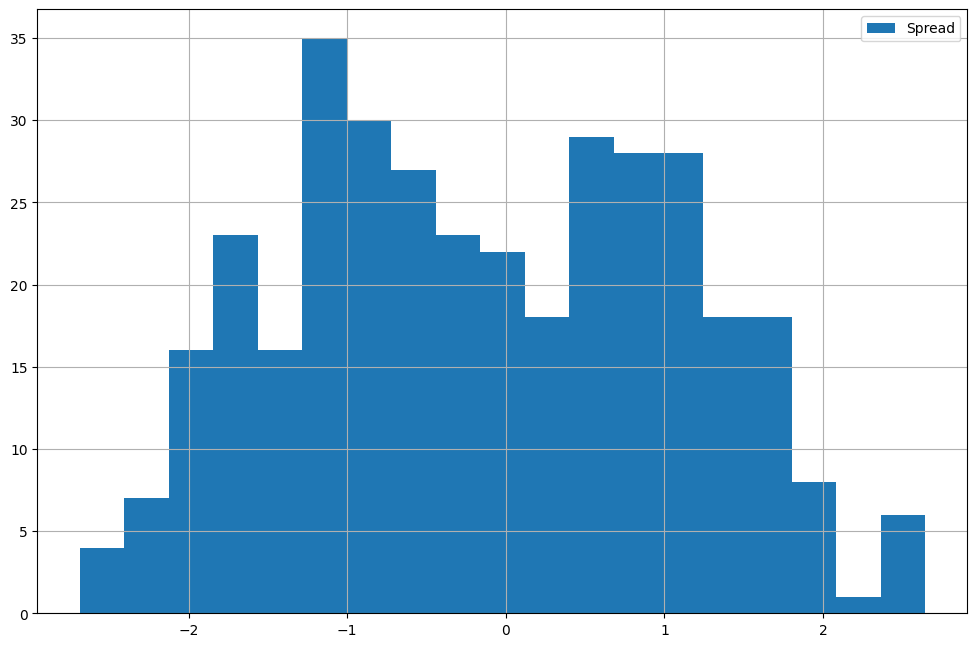

In [8]:

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
n_bins = int(np.ceil(np.sqrt(len(Spread['Z']))))
plt.hist(Spread['Z'],label='Spread',bins=n_bins)
plt.grid()
plt.legend()
plt.show()

In [9]:

dev = 1.5

Spread['P_Threshold'] = abs(((dev * Spread['MSTD']) -  Spread['MA']) /  Spread['MSTD'])
Spread['N_Threshold'] = -abs(((dev * Spread['MSTD']) -  Spread['MA']) /  Spread['MSTD'])
Spread.head()

,Spread,MA,MSTD,Z,P_Threshold,N_Threshold
Date,,,,,,
2019-11-12,0.063690,0.093555,0.027013,-1.105592,1.963359,-1.963359
2019-11-13,0.059233,0.087311,0.027008,-1.039630,1.732788,-1.732788
2019-11-14,0.053582,0.079623,0.024150,-1.078260,1.796952,-1.796952
2019-11-15,0.042783,0.072355,0.023078,-1.281350,1.635201,-1.635201
2019-11-16,0.042231,0.065411,0.020203,-1.147354,1.737696,-1.737696


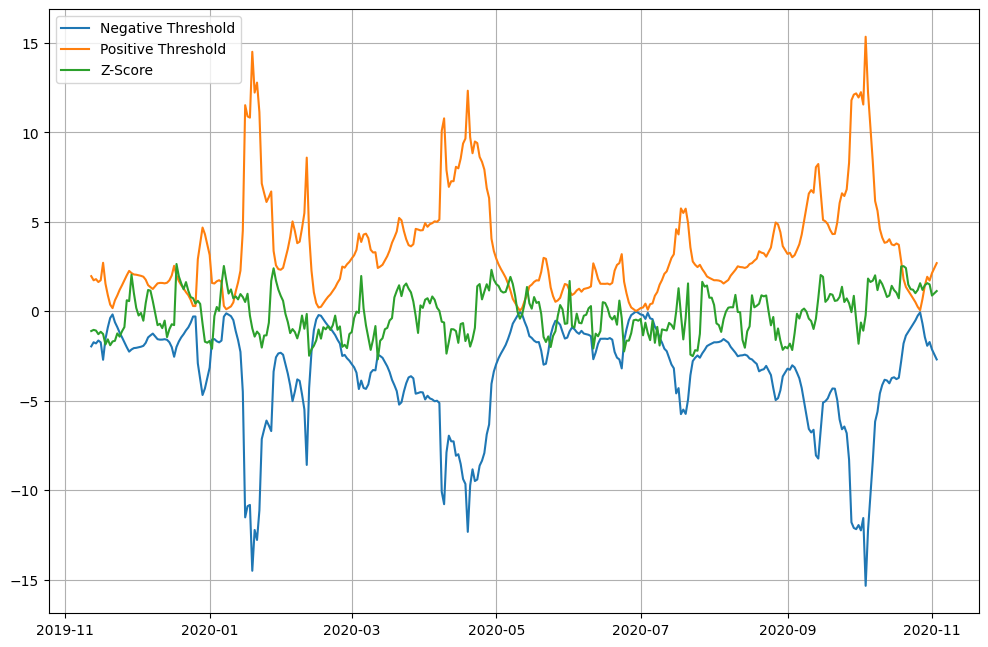

In [10]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(Spread.index.values,Spread['N_Threshold'],label='Negative Threshold')
plt.plot(Spread.index.values,Spread['P_Threshold'],label='Positive Threshold')
plt.plot(Spread.index.values,Spread['Z'],label='Z-Score')
plt.grid()
plt.legend()
plt.show()

In [11]:

def get_actions_SA(Spread):
    actions = [0]
    for _, row in Spread.iterrows():
        if row['Z'] > row['P_Threshold']:
            actions.append(-1)
        elif row['Z'] < row['N_Threshold']:
            actions.append(1)
        else:
            actions.append(actions[-1])
    return actions[1:]

Spread = Spread.join(BTC)
Spread = Spread.join(ETH)
actions = get_actions_SA(Spread)
Spread.head()

,Spread,MA,MSTD,Z,P_Threshold,N_Threshold,Adj Close_BTC,LogPrice_BTC,Adj Close_ETH,LogPrice_ETH
Date,,,,,,,,,,
2019-11-12,0.063690,0.093555,0.027013,-1.105592,1.963359,-1.963359,8815.662109,9.084285,186.843414,5.230271
2019-11-13,0.059233,0.087311,0.027008,-1.039630,1.732788,-1.732788,8808.262695,9.083446,188.258743,5.237817
2019-11-14,0.053582,0.079623,0.024150,-1.078260,1.796952,-1.796952,8708.094727,9.072008,185.999634,5.225745
2019-11-15,0.042783,0.072355,0.023078,-1.281350,1.635201,-1.635201,8491.992188,9.046879,180.521179,5.195848
2019-11-16,0.042231,0.065411,0.020203,-1.147354,1.737696,-1.737696,8550.760742,9.053776,183.348358,5.211388


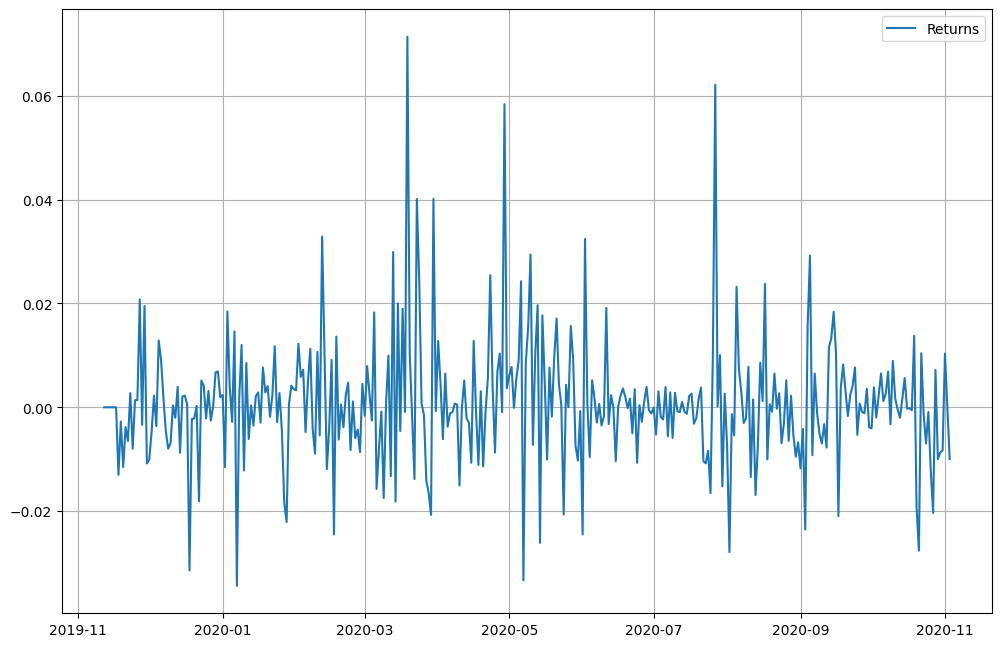

In [12]:
def calculate_return_series(df,actions):
    returns = [0]
    for i, action in enumerate(actions):
        if i > 0:
            row = df.iloc[i]
            prev_row = df.iloc[i-1]
            if action == -1:
                returns.append(
#               LONG
                (n/(1+n))*((row['Adj Close_ETH'] / prev_row['Adj Close_ETH']) - 1) +
#               SHORT
                (1/(1+n))*((prev_row['Adj Close_BTC'] / row['Adj Close_BTC']) - 1)                     
                )
            elif action == 1:
                returns.append(
#               LONG
                (1/(1+n))*((row['Adj Close_BTC'] / prev_row['Adj Close_BTC']) - 1) +
#               SHORT
                (n/(1+n))*((prev_row['Adj Close_ETH'] / row['Adj Close_ETH']) - 1) 
                )
            else:
                returns.append(returns[-1])
    return returns

returns = calculate_return_series(Spread,actions)

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(Spread.index.values,returns,label='Returns')
plt.grid()
plt.legend()
plt.show()

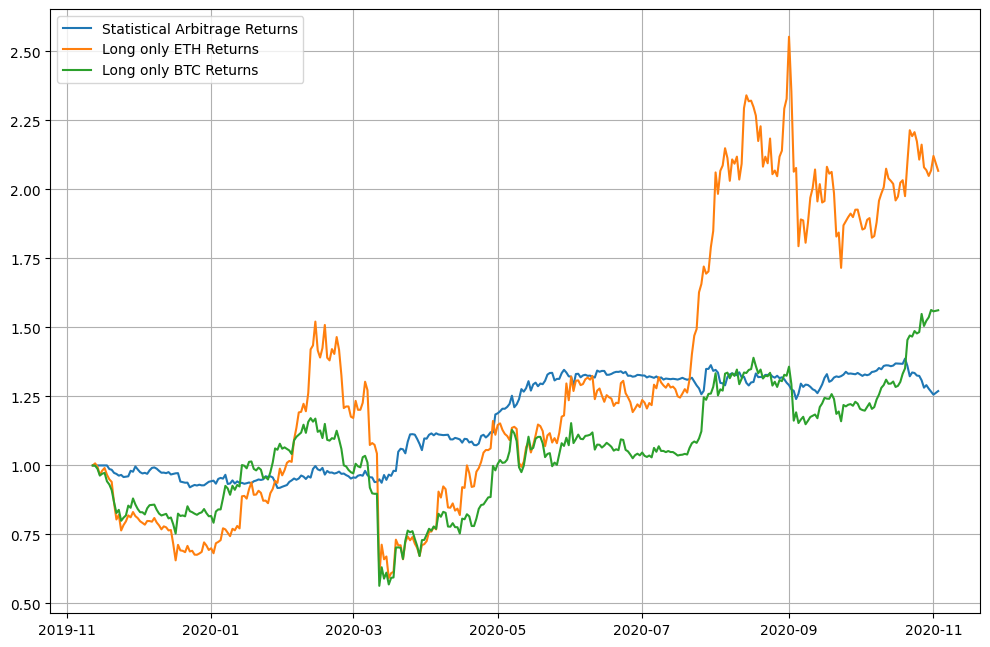

In [13]:
capital = [1]

for ret in returns:
    capital.append(capital[-1] * (1+ret))

capital = capital[:-1]

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(Spread.index.values,capital,label='Statistical Arbitrage Returns')
plt.plot(Spread.index.values,Spread['Adj Close_ETH'] / Spread['Adj Close_ETH'].values[0],label='Long only ETH Returns')
plt.plot(Spread.index.values,Spread['Adj Close_BTC'] / Spread['Adj Close_BTC'].values[0],label='Long only BTC Returns')
plt.grid()
plt.legend()
plt.show()